# Exploring the link between stress-related disorders and tumor pathologies

Documentation: 
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.variants_in_region
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.values
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.donor_grouping

Requirements to run this demo: https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/README_requirements

Try this demo online: https://colab.research.google.com/drive/1eqGmFMKTquOcOXG5K23WSiYSWKT2ZPYg?usp=sharing

Some studies have identified the genes most involved in stress management mechanisms. They encode proteins that regulate the sympathetic system and the HPA axis. It is hypothesized that a malfunction of these genes could cause an inadequate regulation of these mechanisms and consequently behavioural disorders such as bipolarity and depression, cardiovascular diseases like hypertension and coronary artery disease and altered stress response. 
In this demo we ask ourselves if it can exist a link between a dysregulation of stress response and the onset of tumor pathologies. 
Of the genes more involved in stress response regulation, in this demo, for reasons of simplicity, we consider only the gene GR, which determines the functioning of glucocorticoid receptors that, in turn, affect the HPA (hypothalamic-pituitary-adrenocortical) axis. 

### Gene having regulatory function on stress response

In [1]:
stress_genes = ['NR3C1']    # a synonim name of GR. Link to Ensembl gene summary http://apr2020.archive.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000113580;r=5:143277931-143435512

Some utility functions

In [2]:
import requests
import json
import pandas as pd
import csv
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

# make a request and check result
def post_request(to: str, argument, print_status_code=True, print_warnings=True, timeout=None):
    resp = requests.post(to, json=argument, timeout=timeout)
    if print_status_code:
        print(' response status code: {}'.format(resp.status_code))
    res_body = resp.json()
    if resp.status_code != 200:
        print(res_body)
    if print_warnings:
        print('warnings ?: {}'.format(res_body.get('notice')))
    return res_body


# call /variants_in_region and create a list of GENE_NAME + VARIANT
def get_variants_in_gene(genes, health_status:bool, in_cell_type:str) -> list:
    print('collecting variants of genes: ', end='')
    req_body = {
        'name': '!!!    WRITE HERE YOUR GENE NAME       !!!',  # gene name
        'of': {
            'assembly': 'grch38',
            'healthy': health_status,
            'having_variants': {
                'in_cell_type': [in_cell_type]
            }
        }
    }
    # make list of genes with their variants
    container = list()
    for gene in genes:
        print(gene, end='  ')
        req_body['name'] = gene     # set gene
        res = post_request('http://geco.deib.polimi.it/popstudy/api/variants_in_region', req_body, print_status_code=False, print_warnings=False)
        for variant in res['rows']:
            container.append([gene] + variant)  # gene, chrom, start, ref, alt
    return container

### Mutations in gene

In [3]:
stress_mutations = get_variants_in_gene(stress_genes, health_status=False, in_cell_type='somatic')

collecting variants of genes: NR3C1

In [4]:
stress_mutations_df = pd.DataFrame.from_records(stress_mutations, columns=['GENE', 'CHROM', 'START', 'REF', 'ALT'])
stress_mutations_df

,GENE,CHROM,START,REF,ALT
0,NR3C1,5,143279141,G,A
1,NR3C1,5,143279176,A,G
2,NR3C1,5,143279241,T,
3,NR3C1,5,143279250,T,C
4,NR3C1,5,143279252,C,A
...,...,...,...,...,...
178,NR3C1,5,143400765,T,C
179,NR3C1,5,143400775,C,A
180,NR3C1,5,143400813,G,T
181,NR3C1,5,143400818,T,C


### List of diseases with data in Data-Summarization-API

In [5]:
diseases = requests.get('http://geco.deib.polimi.it/popstudy/api/values/disease').json()
diseases = list(diseases.keys())
diseases.remove('none') 
print(diseases)

['acute myeloid leukemia', 'adrenocortical carcinoma', 'bladder urothelial carcinoma', 'brain lower grade glioma', 'breast invasive carcinoma', 'cervical squamous cell carcinoma and endocervical adenocarcinoma', 'cholangiocarcinoma', 'colon adenocarcinoma', 'esophageal carcinoma', 'glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'kidney chromophobe', 'kidney renal clear cell carcinoma', 'kidney renal papillary cell carcinoma', 'liver hepatocellular carcinoma', 'lung adenocarcinoma', 'lung squamous cell carcinoma', 'lymphoid neoplasm diffuse large b-cell lymphoma', 'mesothelioma', 'ovarian serous cystadenocarcinoma', 'pancreatic adenocarcinoma', 'pheochromocytoma and paraganglioma', 'prostate adenocarcinoma', 'rectum adenocarcinoma', 'sarcoma', 'skin cutaneous melanoma', 'stomach adenocarcinoma', 'testicular germ cell tumors', 'thymoma', 'thyroid carcinoma', 'uterine carcinosarcoma', 'uterine corpus endometrial carcinoma', 'uveal melanoma']


### Explore link between variants likely involved in stress-related disorders and cancer types

To this aim, we observe the occurrence of each variant in the patients, grouped by tumor type

In [6]:
# initialize an empty data structure
disease_associated_mutations = pd.concat([stress_mutations_df, pd.DataFrame(columns=diseases)], axis=1)
disease_associated_mutations.fillna(value=0, inplace=True)
disease_associated_mutations

,GENE,CHROM,START,REF,ALT,acute myeloid leukemia,adrenocortical carcinoma,bladder urothelial carcinoma,brain lower grade glioma,breast invasive carcinoma,...,rectum adenocarcinoma,sarcoma,skin cutaneous melanoma,stomach adenocarcinoma,testicular germ cell tumors,thymoma,thyroid carcinoma,uterine carcinosarcoma,uterine corpus endometrial carcinoma,uveal melanoma
0,NR3C1,5,143279141,G,A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NR3C1,5,143279176,A,G,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NR3C1,5,143279241,T,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NR3C1,5,143279250,T,C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NR3C1,5,143279252,C,A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,NR3C1,5,143400765,T,C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179,NR3C1,5,143400775,C,A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,NR3C1,5,143400813,G,T,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,NR3C1,5,143400818,T,C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Fill the prepared data structure

In [7]:
# fill data structure
donor_req = {
    'having_meta': {
        'assembly': 'grch38'
    },
    'having_variants': {
        'in_cell_type': ['somatic'],
        'with': [
            # mutation here
        ]
    },
    'group_by': ['disease']

}
# for each mutation, count how many donors own it, grouped by tumor type
for index, row in tqdm(disease_associated_mutations.iterrows()):
    donor_req['having_variants']['with'] = [{
        'chrom': row['CHROM'], 'start': row['START'], 'ref': row['REF'], 'alt': row['ALT']
    }]
    donor_resp = post_request('http://geco.deib.polimi.it/popstudy/api/donor_grouping', donor_req, print_status_code=False, print_warnings=False)
    # columns are DISEASE and DONORS
    for response_row in donor_resp['rows']:
        disease = response_row[0]
        if disease is not None:
            donors = response_row[1]
            disease_associated_mutations.loc[index, disease] = donors
disease_associated_mutations

183it [02:20,  1.30it/s]


,GENE,CHROM,START,REF,ALT,acute myeloid leukemia,adrenocortical carcinoma,bladder urothelial carcinoma,brain lower grade glioma,breast invasive carcinoma,...,rectum adenocarcinoma,sarcoma,skin cutaneous melanoma,stomach adenocarcinoma,testicular germ cell tumors,thymoma,thyroid carcinoma,uterine carcinosarcoma,uterine corpus endometrial carcinoma,uveal melanoma
0,NR3C1,5,143279141,G,A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,NR3C1,5,143279176,A,G,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,NR3C1,5,143279241,T,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,NR3C1,5,143279250,T,C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,NR3C1,5,143279252,C,A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,NR3C1,5,143400765,T,C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
179,NR3C1,5,143400775,C,A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,NR3C1,5,143400813,G,T,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,NR3C1,5,143400818,T,C,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Explore result

Histogram illustrating the amount of mutations by tumor type

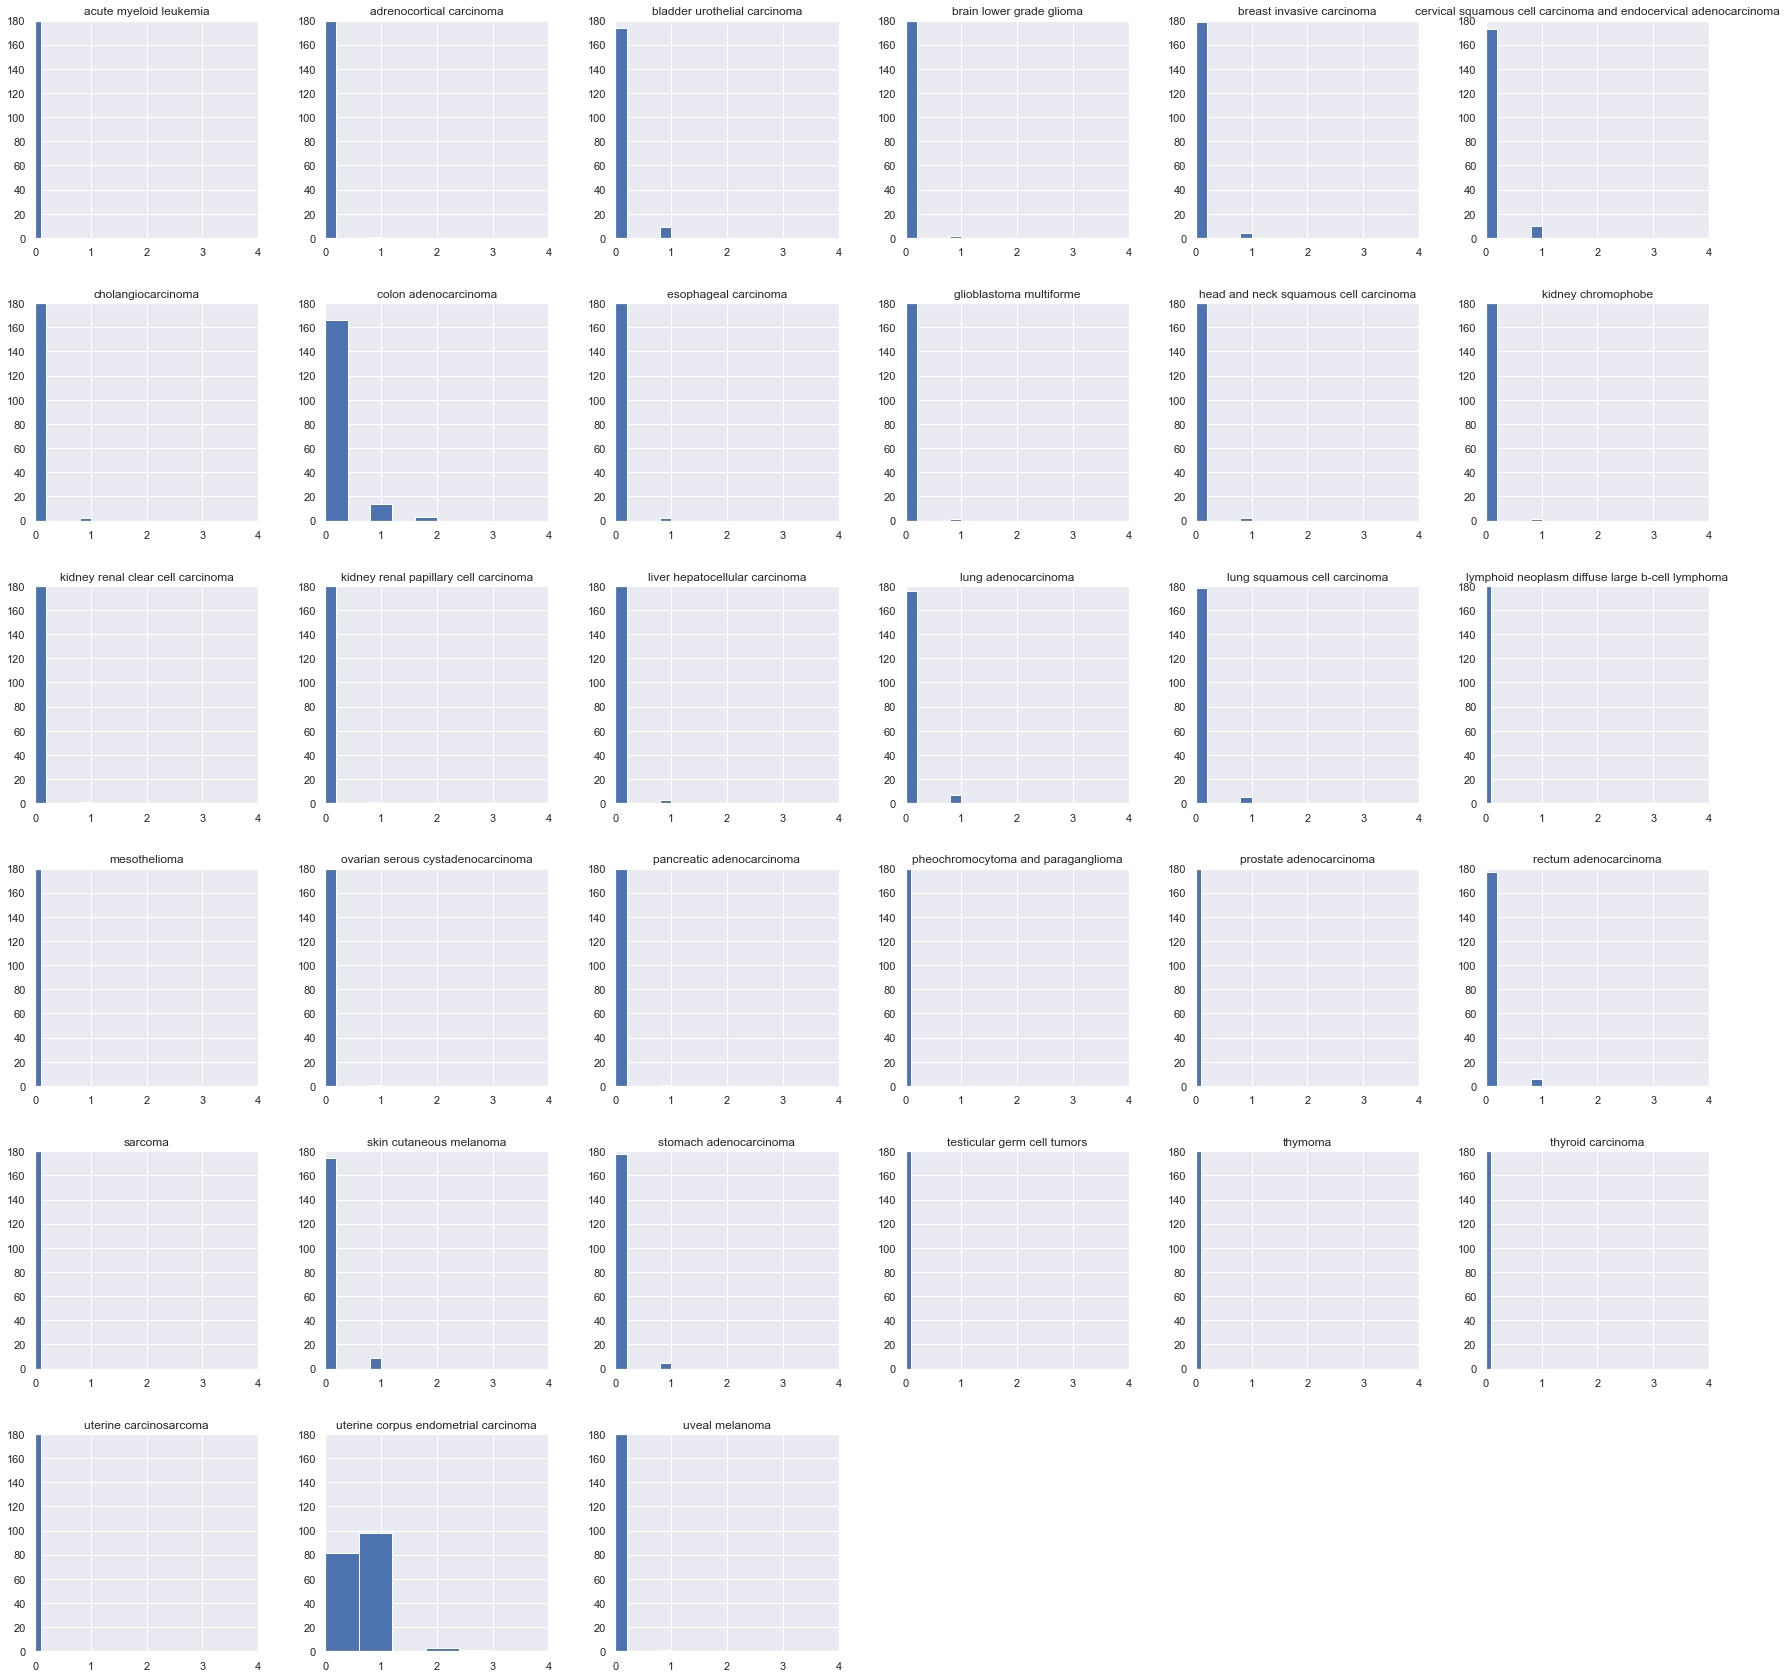

In [8]:
axes = pd.DataFrame.hist(
    disease_associated_mutations, 
    column=diseases,
    bins=5,
    figsize=(30,30)
)
plt.setp(axes, xlim=(0, 4), ylim=(0, 180))
plt.show()

Most of diseases are not related with the gene under examination, but there are some tumor types that show interesting results:
- colon adenocarcinoma
- bladder urothelial carcinoma
- cervical squamous cell carcinoma and endocervical adenocarcinoma
- skin cutaneous melanoma 
- uterine corpus endometrial carcinoma

Out of them, the last one is the one that shows the highest number of mutations in the gene GR (NR3C1)

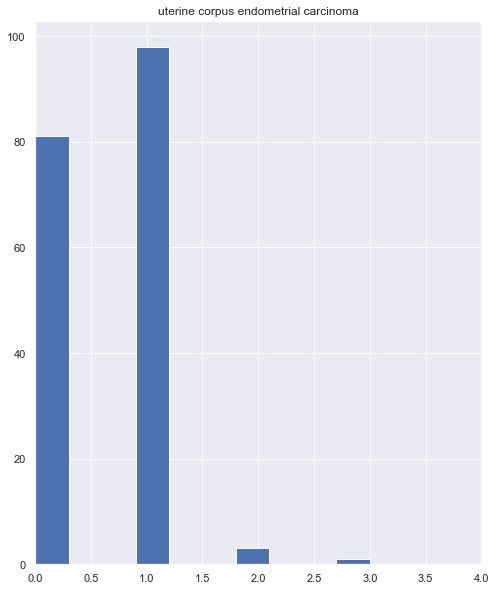

In [9]:
pd.DataFrame.hist(
    disease_associated_mutations, 
    column='uterine corpus endometrial carcinoma',
    figsize=(8, 10)
)
plt.xlim([0, 4])
plt.show()

Out of 183 mutations in the GR gene, almost 100 are present in patients having uterine corpus endometrial carcinoma. 

### This result shows an interesting link between this form of cancer (uterine corpus endometrial carcinoma) and a gene (GR - also known as NR3C1) whose primary function is the regulation of the stress response.